In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
titanic_data = pd.read_csv("train.csv")

In [3]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


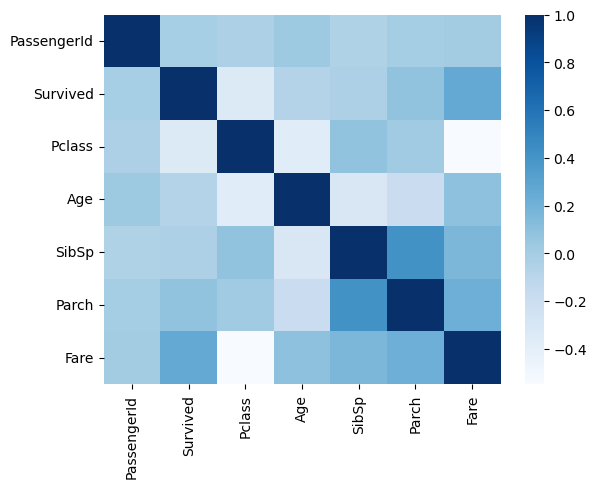

In [4]:
import seaborn as sns

sns.heatmap(titanic_data.corr(), cmap="Blues")
plt.show()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indecies, test_indecies in split.split(titanic_data, titanic_data[["Survived", "Pclass","Sex"]]):
    strat_train_set = titanic_data.loc[train_indecies]
    strat_test_set = titanic_data.loc[test_indecies]

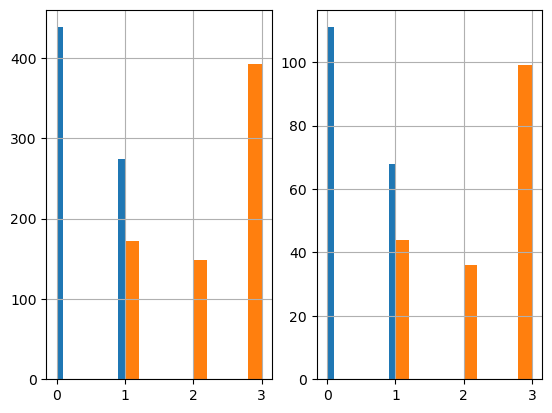

In [9]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [10]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 729 to 152
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          569 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [27]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X


In [28]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [29]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer() ),
                     ("featureencoder", FeatureEncoder() ),
                     ("featuredropper", FeatureDropper() )])

In [30]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [31]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
729,730,0,3,25.000000,1,0,7.9250,0.0,0.0,1.0,1.0,0.0
763,764,1,1,36.000000,1,2,120.0000,0.0,0.0,1.0,1.0,0.0
188,189,0,3,40.000000,1,1,15.5000,0.0,1.0,0.0,0.0,1.0
640,641,0,3,20.000000,0,0,7.8542,0.0,0.0,1.0,0.0,1.0
649,650,1,3,23.000000,0,0,7.5500,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
367,368,1,3,29.645132,0,0,7.2292,1.0,0.0,0.0,1.0,0.0
326,327,0,3,61.000000,0,0,6.2375,0.0,0.0,1.0,0.0,1.0
266,267,0,3,16.000000,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
482,483,0,3,50.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [32]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 729 to 152
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [34]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [43]:
final_clf = grid_search.best_estimator_

In [44]:
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=200)

In [45]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [46]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
10,11,1,3,4.000000,1,1,16.7000,0.0,0.0,1.0,1.0,0.0
583,584,0,1,36.000000,0,0,40.1250,1.0,0.0,0.0,0.0,1.0
257,258,1,1,30.000000,0,0,86.5000,0.0,0.0,1.0,1.0,0.0
49,50,0,3,18.000000,1,0,17.8000,0.0,0.0,1.0,1.0,0.0
591,592,1,1,52.000000,1,0,78.2667,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
508,509,0,3,28.000000,0,0,22.5250,0.0,0.0,1.0,0.0,1.0
341,342,1,1,24.000000,3,2,263.0000,0.0,0.0,1.0,1.0,0.0
427,428,1,2,19.000000,0,0,26.0000,0.0,0.0,1.0,1.0,0.0
82,83,1,3,29.910966,0,0,7.7875,0.0,1.0,0.0,1.0,0.0


In [47]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [48]:
final_clf.score(X_data_test, y_data_test)

0.8212290502793296

In [49]:
final_data = pipeline.fit_transform(titanic_data)

In [50]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [51]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()

X_final_data = scaler.fit_transform(X_final)
y_final_data = y_final.to_numpy()

In [52]:
final_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(final_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_final_data, y_final_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [53]:
prod_final_clf = grid_search.best_estimator_

In [54]:
prod_final_clf

RandomForestClassifier(max_depth=5, n_estimators=500)

In [55]:
titanic_test_data = pd.read_csv("test.csv")

In [56]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [58]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()

X_data_final_test = scaler.fit_transform(X_final_test)

In [59]:
predictions = prod_final_clf.predict(X_data_final_test)

In [65]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("predictions_1.csv", index=False)

In [66]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
